In this notebook I will re-fit the free parameters of the Krisciunas & Schaefer (1991) moon model using BOSS sky fiber data. The free parameters I will be fitting are $C_R$, $C_{M,0}$, $C_{M,1}$ of the scattering function $f(\rho)$. 

__Krisciunas & Schaefer (1991)__ model
$$B_\mathrm{moon} = f(\rho) I^* 10^{-0.4 k\,X(Z_m)} [1 - 10^{-0.4 k\,X(Z)}]$$
where
$$f(\rho) = f_R(\rho) + f_M(\rho) = C_R [1.06 + cos^2(\rho)] + 10^{C_{M,0} - \rho/C_{M,1}}$$

Original values for the parameters are 

$C_R = 10^{5.36}$, $C_{M,0} = 6.15$, and $C_{M,1} = 40.$. 

In [1]:
import numpy as np 
import scipy.optimize as sciop
# -- astropy -- 
import astropy.units as u
from astropy.table import Table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets read in the BOSS sky fluxes and their corresponding meta data

In [3]:
boss_blue = aTable.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

(0.0, 1.0)

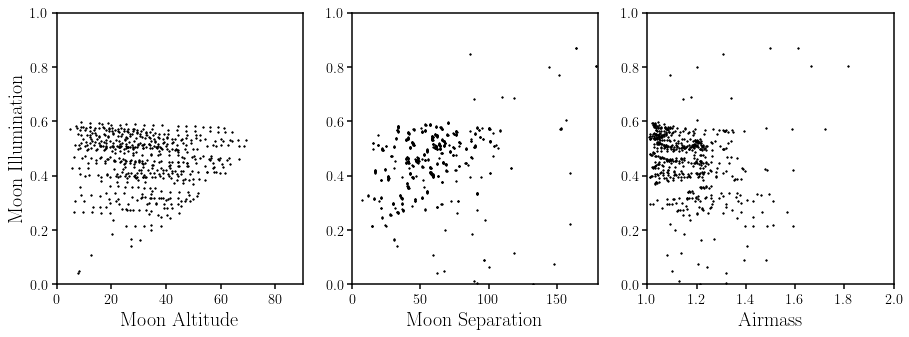

In [4]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [5]:
specsim_sky = Sky.specsim_initialize('desi')

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [6]:
specsim_wave = specsim_sky._wavelength # Ang

In [7]:
cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1
print('Default C_R = %f, C_M0 = %f, C_M1 = %f' % (cr_def, cm0_def, cm1_def))

Default C_R = 229086.765277, C_M0 = 6.150000, C_M1 = 40.000000


In [8]:
def KS_sky(airmass, moonill, moonalt, moonsep, cr, cm0, cm1): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr
    specsim_sky.moon.KS_CM0 = cm0 
    specsim_sky.moon.KS_CM1 = cm1 
    return specsim_sky.surface_brightness

Lets compare BOSS sky surface brightnesses to the default UVES + KS sky brightness

Text(0.5,0,'wavelength')

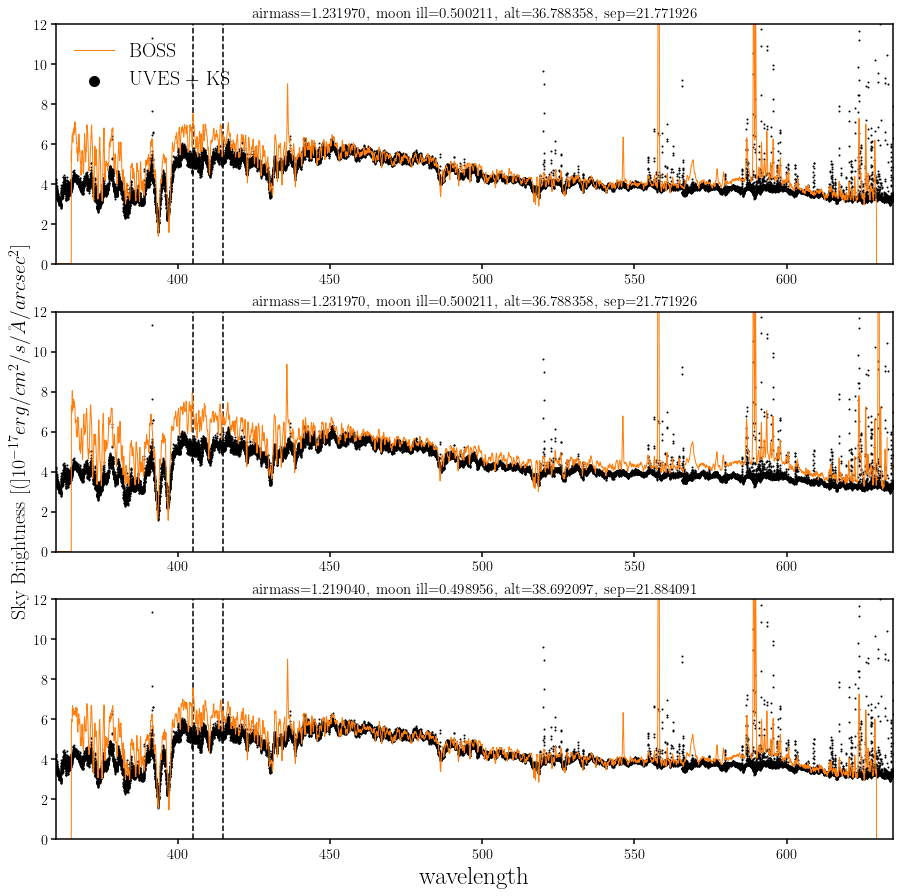

In [9]:
fig = plt.figure(figsize=(15,15))
for ii, i in enumerate([0, 1, 2]):#np.random.choice(range(len(blue_skyavg)), 3, replace=False)):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='C1', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='k', label='UVES + KS')
    sub.vlines(405., 0., 12, color='k', linestyle='--')
    sub.vlines(415., 0., 12, color='k', linestyle='--')
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

Lets focus on the sky brightness at a specific blue wavelength that's not too noisy: $4100A$. 

In [10]:
boss_wlim410 = ((boss_blue[0]['WAVE'] > 405.) & (boss_blue[0]['WAVE'] < 415.))
boss_sky410 = np.array([np.average(boss_blue[i]['SKY'][boss_wlim410])/np.pi for i in range(len(boss_blue))])

In [11]:
ks_wlim410 = ((specsim_wave.value > 4050.) & (specsim_wave.value < 4150.))
ks_sky410 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    ks_sky410[i] = np.average(ks_i.value[ks_wlim410])

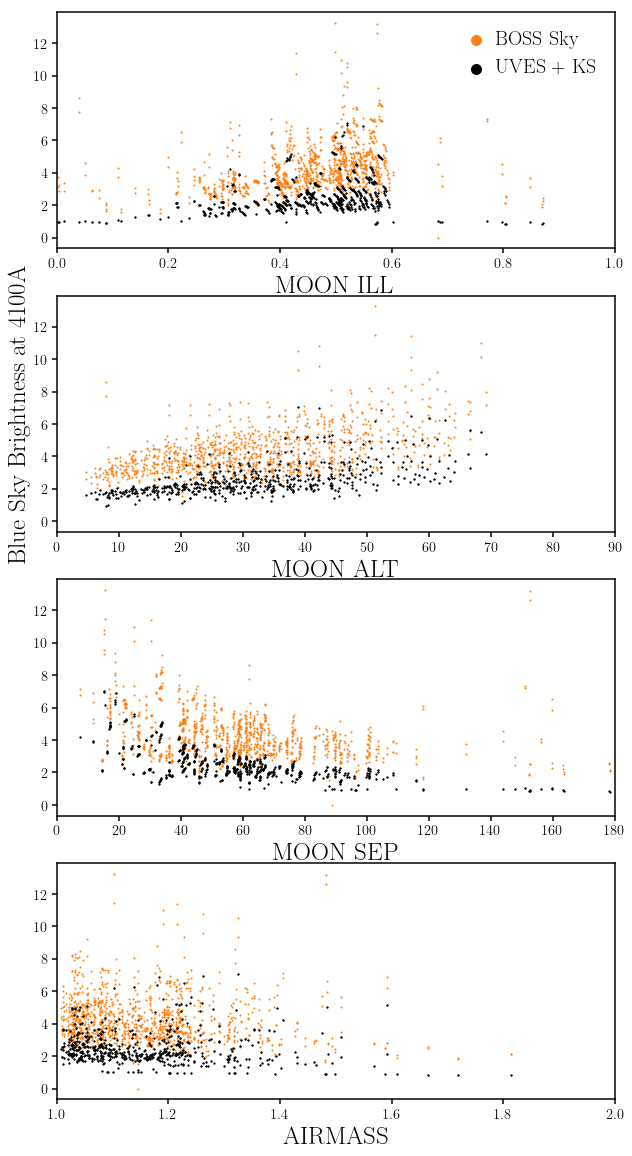

In [12]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410, c='C1', s=1, label='BOSS Sky')
    sub.scatter(boss_blue[k], ks_sky410, c='k', s=1, label='UVES + KS')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('Blue Sky Brightness at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])

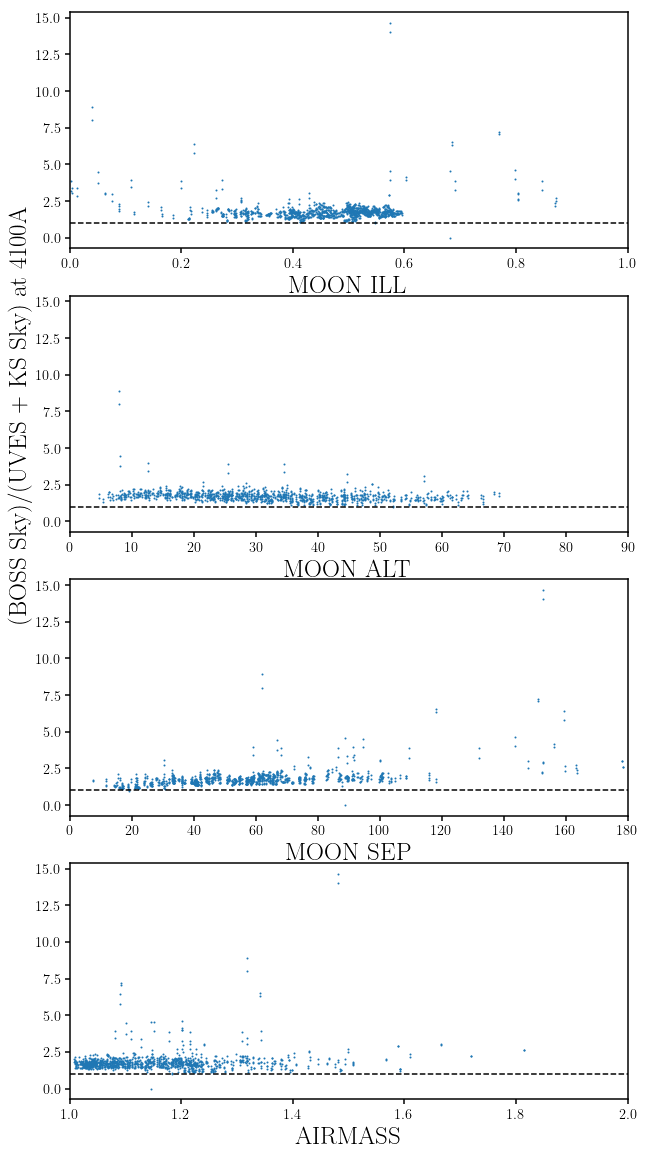

In [13]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410/ks_sky410, c='C0', s=1)
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

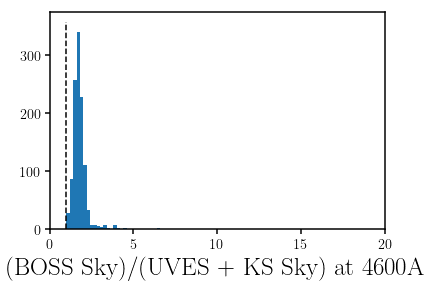

In [55]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(boss_sky410/ks_sky410, range=(0., 20.), bins=100)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) at 4600A', fontsize=25)
sub.set_xlim([0., 20.])
#sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

Now lets fit $C_R$, $C_{M,0}$, and $C_{M,1}$ to better reproduce the sky brightness at $\sim4100A$

In [15]:
def L2_sky410(cs): 
    '''calculate the total L2 norm between the predicted 
    UVES+KSsky(theta, CR, CM0, CM1) and the BOSSsky(theta)
    '''
    cr, cm0, cm1 = cs
    # calculate UVES + KS sky (theta, C_R, C_M0, C_M1)
    i_s = np.arange(len(boss_blue))[::10]
    sky410 = np.zeros(len(i_s))
    for ii, i in enumerate(i_s): 
        ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr, cm0, cm1)
        sky410[ii] = np.average(ks_i.value[ks_wlim410])
    return np.sum((boss_sky410[::10] - sky410)**2)

In [16]:
x0 = [2.*cr_def, cm0_def, cm1_def]
theta_min = sciop.minimize(L2_sky410, x0)

In [22]:
print('Default C_R = 10^%f, C_M0 = %f, C_M1 = %f' % (np.log10(cr_def), cm0_def, cm1_def))
print('New C_R = 10^%f, C_M0 = %f, C_M1 = %f' % (np.log10(theta_min['x'][0]), theta_min['x'][1], theta_min['x'][2]))

Default C_R = 10^5.360000, C_M0 = 6.150000, C_M1 = 40.000000
New C_R = 10^5.661030, C_M0 = 5.540103, C_M1 = 178.141045


In [17]:
ks_new_sky410 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  theta_min['x'][0], theta_min['x'][1], theta_min['x'][2])
    ks_new_sky410[i] = np.average(ks_i.value[ks_wlim410])

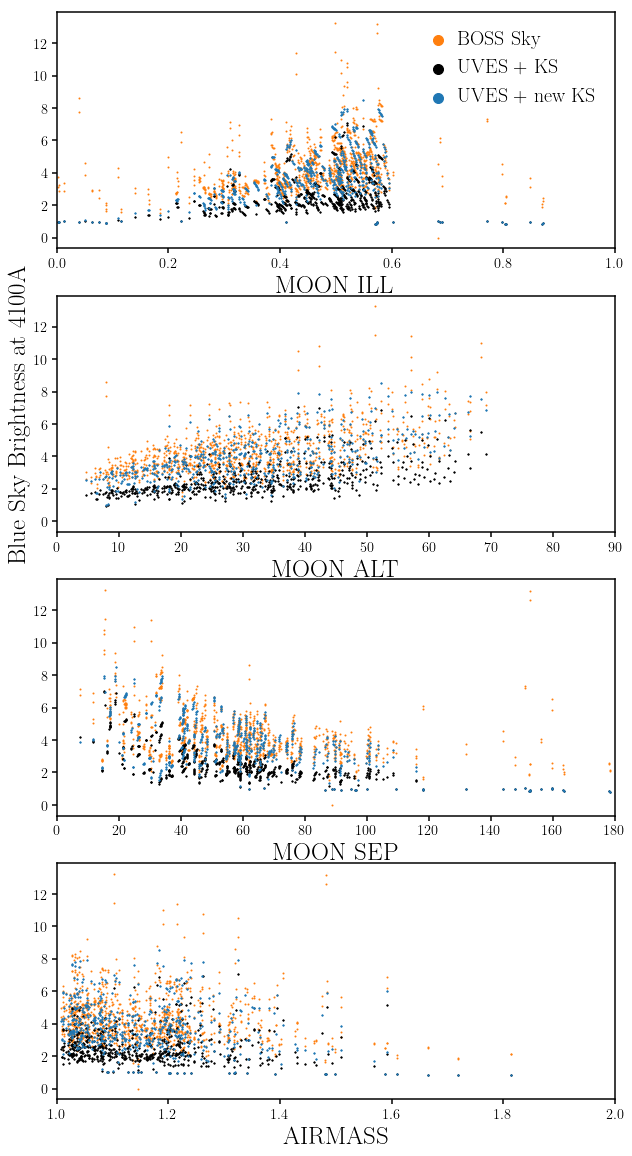

In [18]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410, c='C1', s=1, label='BOSS Sky')
    sub.scatter(boss_blue[k], ks_sky410, c='k', s=1, label='UVES + KS')
    sub.scatter(boss_blue[k], ks_new_sky410, c='C0', s=1, label='UVES + new KS')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('Blue Sky Brightness at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])

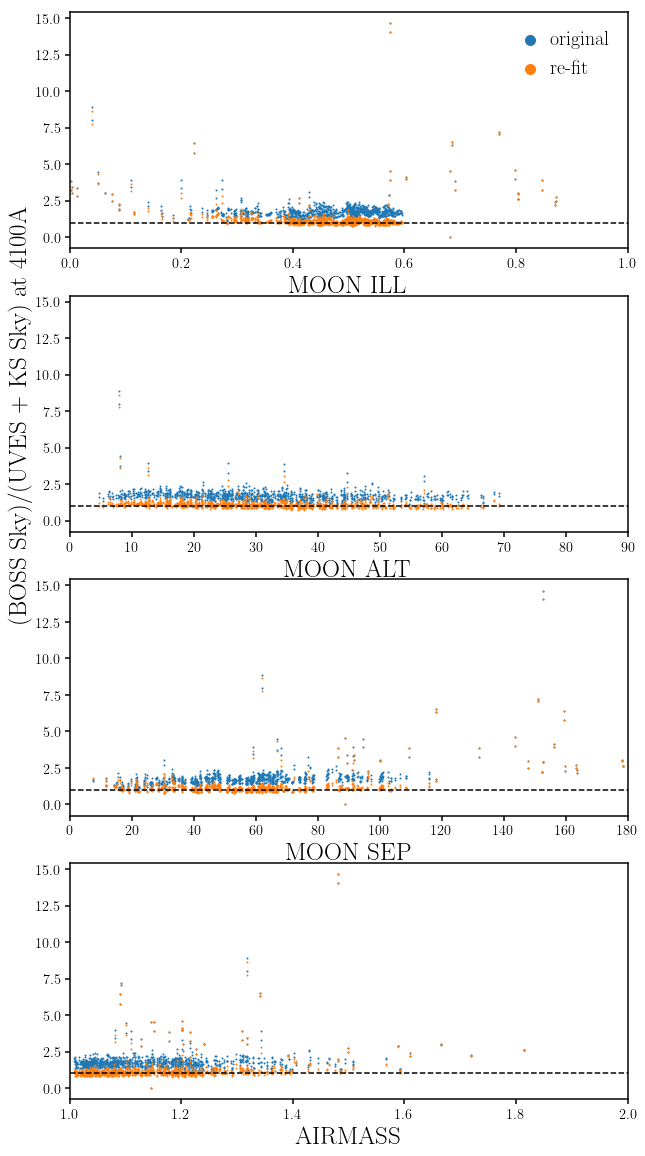

In [19]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410/ks_sky410, c='C0', s=1, label='original')
    sub.scatter(boss_blue[k], boss_sky410/ks_new_sky410, c='C1', s=1, label='re-fit')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

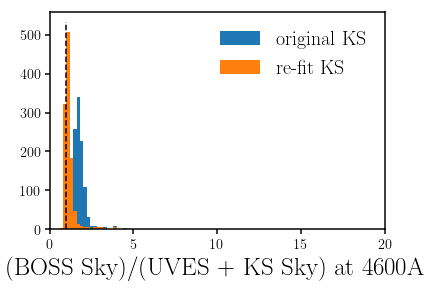

In [54]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(boss_sky410/ks_sky410, range=(0., 20.), bins=100, label='original KS')
sub.hist(boss_sky410/ks_new_sky410, range=(0., 20.), bins=100, label='re-fit KS')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) at 4600A', fontsize=25)
sub.set_xlim([0., 20.])
#sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')